In [40]:
import os
from os.path import join
from Bio import Phylo
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from datetime import datetime

MODEL = 'S6A'
LOG_FORMAT = '%(asctime)s - %(levelname)s - %(message)s'

# ─── PARAMETERS ────────────────────────────────────────────────────────────────
DIR_WORKING = "/Users/u7875558/RNAPhylo/fullAlignment_S6A"
DIR_OUTPUTS = join(DIR_WORKING, "outputs")
DIR_RF = join(DIR_OUTPUTS, 'Robinson_Foulds_iqtree3')
DIR_RF_LOGS = join(DIR_WORKING, "logs", "RF_distance")
os.makedirs(DIR_RF_LOGS, exist_ok=True)

SUFFIXES     = {
    'DNA vs DNA':  '.raxml.rfdist',
    'DNA vs RNA':  '.raxml.raxmlPi.rfdist',
    'RNA vs RNA': '.raxmlPi.rfdist'
}

# A. Produce a dataframe containing all normalised RF distances of FULL dataset (only S6A model)

In [41]:
# control the number of RF distance files -- There should be 3
for rna in os.listdir(DIR_RF):
    rfdist_file = 0
    rna_path = join(DIR_RF, rna)
    if os.path.isdir(rna_path):
        for f in os.listdir(rna_path):
            if f.endswith('rfdist'):
                rfdist_file += 1
        
    if rfdist_file!=3:
        print(rna)

Utest_pvalues_ignore_pseudoknots_wide.csv
Utest_pvalues_wide.csv
Utest_pvalues_long.csv
Utest_pvalues_ignore_pseudoknots_long.csv


In [42]:
# ─── UTILITY FUNCTIONS ────────────────────────────────────────────────────────

def read_rfdist(path):
    """Read an RF distance matrix file into a NumPy array."""
    with open(path) as f:
        lines = f.readlines()[1:]  # skip header
    mat = [list(map(float, row.strip().split()[1:])) for row in lines]
    return np.array(mat)

def summarize_normalized(mat):
    """L2-normalize a matrix and return its mean and median (flattened)."""
    norm = normalize(mat, norm='l2')
    flat = norm.flatten()
    return float(flat.mean()), float(np.median(flat))

# ─── MAIN PROCESSING ──────────────────────────────────────────────────────────

log_filename = os.path.join(DIR_RF_LOGS, f"{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.medianRF.{MODEL}.log")
logging.basicConfig(filename=log_filename, level=logging.DEBUG, format=LOG_FORMAT)
logging.info(f"Running the code with the model {MODEL}.")

all_records = []

for rna in os.listdir(DIR_RF):
    rna_dir = join(DIR_RF, rna)
    
    for category, suffix in SUFFIXES.items():
        file_path = join(rna_dir, f"{rna}{suffix}")

        if not os.path.exists(file_path):
            continue
        mat = read_rfdist(file_path)
        mean_rf, med_rf = summarize_normalized(mat)

        all_records.append({
            'RNA': rna,
            'Category': category,
            'Mean RF': mean_rf,
            'Median RF': med_rf
        })

df = pd.DataFrame(all_records)

In [77]:
df[df['RNA']=='RF00001']

,RNA,Category,Mean RF,Median RF
8253,RF00001,DNA vs DNA,0.299642,0.332446
8254,RF00001,DNA vs RNA,0.316181,0.316471
8255,RF00001,RNA vs RNA,0.299822,0.332890


In [44]:
# sort out RNA families having median RF > 0.3
df[df['Median RF'] > 0.35]['RNA'].drop_duplicates()

60      RF03857
74      RF00870
108     RF01360
162     RF02715
170     RF02371
         ...   
8268    RF01785
8290    RF03442
8324    RF03677
8340    RF00462
8406    RF01586
Name: RNA, Length: 154, dtype: object

In [45]:
df[df['RNA']=='RF03857']

,RNA,Category,Mean RF,Median RF
60,RF03857,DNA vs DNA,0.252528,0.353553
61,RF03857,DNA vs RNA,0.244949,0.408248
62,RF03857,RNA vs RNA,0.000000,0.000000


# B. Figures

## 1. Figure showing all median RF (DNA vs DNA, DNA vs RNA, RNA vs RNA)

/var/folders/7l/28yzqfm93j105y85x5rns4bryc93vy/T/ipykernel_78382/336998992.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


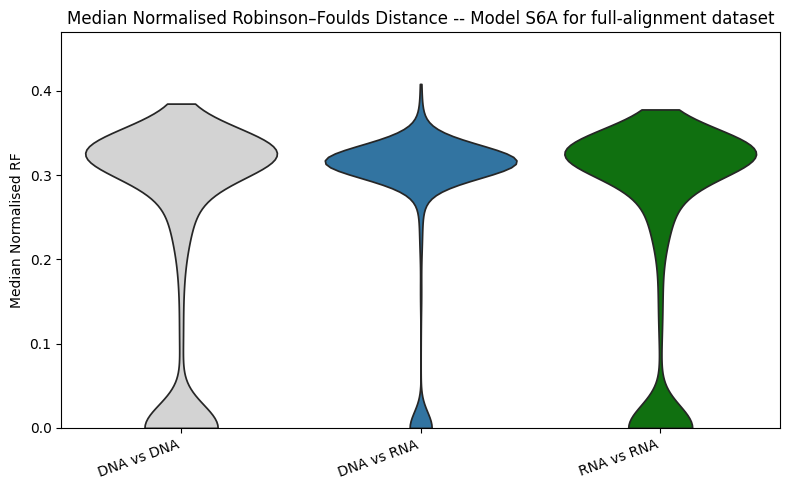

Group medians:
Category
DNA vs DNA    0.3196
DNA vs RNA    0.3162
RNA vs RNA    0.3210
Name: Median RF, dtype: float64

Group means:
Category
DNA vs DNA    0.2386
DNA vs RNA    0.2852
RNA vs RNA    0.2463
Name: Median RF, dtype: float64


In [46]:
# We’ll plot only these two categories from this table
order = ['DNA vs DNA', 'DNA vs RNA', 'RNA vs RNA']

# Keep only rows we need and drop any NaNs in the y column
df_plot = (
    df[df['Category'].isin(order)]
      .copy()
      .dropna(subset=['Median RF'])
)

# Colors: light gray for DNA vs DNA; pick a distinct color for DNA vs RNA
palette = {
    'DNA vs DNA': 'lightgray',
    'DNA vs RNA': '#1f77b4',  # blue; change if you prefer another color
    'RNA vs RNA': 'green'
}

# Compute a little headroom for the y-axis
ymax = df_plot['Median RF'].max()

plt.figure(figsize=(8, 5))
sns.violinplot(
    data=df_plot,
    x='Category',
    y='Median RF',
    order=order,
    palette=palette,
    cut=0,        # don’t extend beyond the data; keeps bottom at 0 cleanly
    inner=None    # no internal box/median lines
)

plt.ylim(0, ymax * 1.15)   # bottom pinned at 0; top auto with headroom
plt.xticks(rotation=20, ha='right')
plt.title('Median Normalised Robinson–Foulds Distance -- Model S6A for full-alignment dataset')
plt.ylabel('Median Normalised RF')
plt.xlabel('')
plt.tight_layout()
plt.show()

# (optional) print quick summaries
print("Group medians:")
print(df_plot.groupby('Category')['Median RF'].median().round(4))
print("\nGroup means:")
print(df_plot.groupby('Category')['Median RF'].mean().round(4))

/var/folders/7l/28yzqfm93j105y85x5rns4bryc93vy/T/ipykernel_78382/3078454335.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


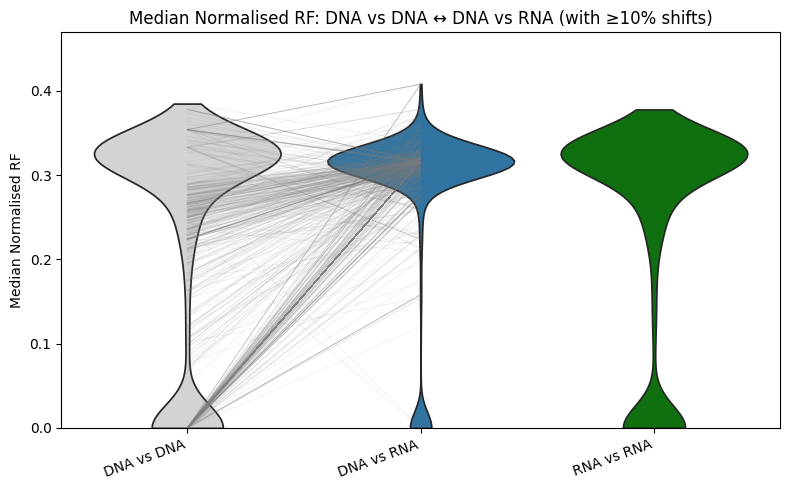

Lines drawn (≥10% change): 771 / 2828


In [48]:
# --- keep only the two categories we care about ---
order = ['DNA vs DNA', 'DNA vs RNA', 'RNA vs RNA']
df_plot = (
    df[df['Category'].isin(order)]
      .copy()
      .dropna(subset=['Median RF'])
)

# --- colors ---
palette = {
    'DNA vs DNA': 'lightgray',   # baseline
    'DNA vs RNA': '#1f77b4',     # blue
    'RNA vs RNA': 'green'
}

# --- figure: violins first ---
ymax = df_plot['Median RF'].max()
plt.figure(figsize=(8, 5))
sns.violinplot(
    data=df_plot,
    x='Category',
    y='Median RF',
    order=order,
    palette=palette,
    cut=0,          # trim to actual min/max (bottom pinned at 0 by ylim below)
    inner=None
)

# --- connecting lines: only if >=10% relative change after rounding ---
THRESHOLD = 0.10   # 10%
ROUND = 3          # round to 3 decimals before comparing

# pivot to wide so each RNA has both values on one row
wide = (
    df_plot.pivot(index='RNA', columns='Category', values='Median RF')
           .reindex(columns=order)
)

lines_drawn = 0
for rna, row in wide.iterrows():
    v1, v2 = row['DNA vs DNA'], row['DNA vs RNA']
    if pd.isna(v1) or pd.isna(v2):
        continue
    # round to stabilize tiny numerical noise
    v1r, v2r = np.round(v1, ROUND), np.round(v2, ROUND)

    # relative change vs baseline (handle zero safely)
    if v1r > 0:
        rel = abs(v2r - v1r) / v1r
    else:
        rel = abs(v2r - v1r)  # fall back to absolute difference

    if rel >= THRESHOLD:
        plt.plot(
            [0, 1], [v1r, v2r],
            color='gray', alpha=0.12, linewidth=0.6, zorder=2
        )
        lines_drawn += 1

plt.ylim(0, ymax * 1.15)
plt.xticks(rotation=20, ha='right')
plt.title('Median Normalised RF: DNA vs DNA ↔ DNA vs RNA (with ≥10% shifts)')
plt.ylabel('Median Normalised RF')
plt.xlabel('')
plt.tight_layout()
plt.show()

print(f"Lines drawn (≥{int(THRESHOLD*100)}% change): {lines_drawn} / {wide.dropna().shape[0]}")


## 2. Due to the similarity of the plots --> showing the number of families having the value in the range 0.3-0.4

In [56]:
# show the number of families having median RF in range [0.3,0.4]

df[(df['Median RF'] > 0.31) & (df['Median RF'] < 0.35)& (df['Category']=='DNA vs DNA')]

,RNA,Category,Mean RF,Median RF
0,RF04271,DNA vs DNA,0.299427,0.332923
3,RF03054,DNA vs DNA,0.299661,0.333217
15,RF00087,DNA vs DNA,0.299618,0.329525
24,RF02724,DNA vs DNA,0.290042,0.313680
27,RF00073,DNA vs DNA,0.299763,0.332316
...,...,...,...,...
8460,RF01747,DNA vs DNA,0.299909,0.333006
8472,RF00008,DNA vs DNA,0.299844,0.333962
8475,RF02935,DNA vs DNA,0.299826,0.330293
8478,RF03813,DNA vs DNA,0.298557,0.329315


In [58]:
df[(df['Median RF'] > 0.31) & (df['Median RF'] < 0.35) & (df['Category']=='DNA vs RNA')]

,RNA,Category,Mean RF,Median RF
1,RF04271,DNA vs RNA,0.316130,0.316537
4,RF03054,DNA vs RNA,0.316118,0.315240
7,RF03266,DNA vs RNA,0.316228,0.316228
10,RF01531,DNA vs RNA,0.315445,0.316228
16,RF00087,DNA vs RNA,0.315897,0.316627
...,...,...,...,...
8470,RF00834,DNA vs RNA,0.316228,0.316228
8473,RF00008,DNA vs RNA,0.316188,0.315244
8476,RF02935,DNA vs RNA,0.316145,0.316068
8479,RF03813,DNA vs RNA,0.316207,0.315896


In [59]:
df[(df['Median RF'] > 0.31)  & (df['Median RF'] < 0.35) & (df['Category']=='RNA vs RNA')]

,RNA,Category,Mean RF,Median RF
2,RF04271,RNA vs RNA,0.299502,0.331826
5,RF03054,RNA vs RNA,0.299499,0.331432
17,RF00087,RNA vs RNA,0.299759,0.332340
23,RF03430,RNA vs RNA,0.289442,0.317412
26,RF02724,RNA vs RNA,0.294818,0.320708
...,...,...,...,...
8462,RF01747,RNA vs RNA,0.299887,0.332131
8474,RF00008,RNA vs RNA,0.299880,0.332829
8477,RF02935,RNA vs RNA,0.299742,0.332638
8480,RF03813,RNA vs RNA,0.299596,0.331481


# C. Compute the p-values

## 1. L2-normalisation of the RF matrix

In [62]:
"""
Compute Mann–Whitney U-test p-values for median normalised RF distances.

Compares, per RNA and per model:
    DNA vs DNA  (file: <RNA>.raxml.rfdist; uses upper triangle only)
        vs
    DNA vs RNA  (ignore pseudoknots; file: <RNA>.raxml.raxmlPi.rfdist; uses all cells)

Outputs:
  1) long table:  Model, RNA, n_DNA, n_RNA, U, pvalue
  2) wide table:  index = RNA, columns = Model, values = pvalue

No p-value adjustment is performed here.
"""

import os
from os.path import join, isdir
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize
from scipy.stats import mannwhitneyu


# ─── PATHS (edit these to your environment) ────────────────────────────────────
DIR_WORKING = "/Users/u7875558/RNAPhylo/fullAlignment_S6A"
DIR_OUTPUTS = join(DIR_WORKING, "outputs")
DIR_RF = join(DIR_OUTPUTS, 'Robinson_Foulds_iqtree3') # where <MODEL>/<RNA>/<RNA>.*.rfdist live

MODEL='S6A'

# filenames we expect inside each RNA folder
DNA_RFDIST_SUFFIX        = '.raxml.rfdist'       # DNA vs DNA
DNA_VS_RNA_IPSEU_SUFFIX  = '.raxml.raxmlPi.rfdist'  # DNA vs RNA (ignore pseudoknots)


# ─── I/O utilities ─────────────────────────────────────────────────────────────

def read_rfdist_matrix(path: str) -> np.ndarray:
    """
    Read an IQ-TREE .rfdist square matrix into a 2D NumPy array.
    Skips the first line (header). Returns empty array if file is empty.
    """
    with open(path, 'r') as f:
        lines = f.readlines()
    if len(lines) <= 1:
        return np.array([])  # no data rows
    rows = []
    for line in lines[1:]:
        parts = line.strip().split()
        if len(parts) <= 1:
            continue
        # skip first token (row label), rest are numbers
        vals = list(map(float, parts[1:]))
        rows.append(vals)
    return np.array(rows, dtype=float) if rows else np.array([])


def norm_upper_triangle(mat: np.ndarray) -> np.ndarray:
    """L2-normalize mat and return the upper triangle (k=1) flattened."""
    if mat.size == 0:
        return np.array([])
    if mat.ndim == 1:
        mat = mat.reshape(1, -1)
    n = mat.shape[0]
    norm = normalize(mat, norm='l2')
    iu = np.triu_indices(n, k=1)
    return norm[iu].astype(float)


def norm_full_flat(mat: np.ndarray) -> np.ndarray:
    """L2-normalize mat and return all entries flattened."""
    if mat.size == 0:
        return np.array([])
    if mat.ndim == 1:
        mat = mat.reshape(1, -1)
    norm = normalize(mat, norm='l2')
    return norm.flatten().astype(float)


# ─── Core computation ──────────────────────────────────────────────────────────
def compute_utest_for_model(model: str) -> pd.DataFrame:
    """
    For a given model, iterate RNA folders and compute U-test p-values between:
      DNA vs DNA  (raxml.rfdist upper triangle)  vs
      DNA vs RNA  (raxml.raxmlPi.rfdist full matrix)
    Returns a DataFrame with columns: Model, RNA, n_DNA, n_RNA, U, pvalue
    """
    model_dir = join(DIR_RF)
    if not isdir(model_dir):
        return pd.DataFrame(columns=['Model','RNA','n_DNA','n_RNA','U','pvalue'])

    records = []
    for rna in sorted(os.listdir(model_dir)):
        rna_dir = join(model_dir, rna)
        if not isdir(rna_dir):
            continue

        dna_fp   = join(rna_dir, f'{rna}{DNA_RFDIST_SUFFIX}')
        ipseu_fp = join(rna_dir, f'{rna}{DNA_VS_RNA_IPSEU_SUFFIX}')
        if not (os.path.exists(dna_fp) and os.path.exists(ipseu_fp)):
            continue

        dna_mat   = read_rfdist_matrix(dna_fp)
        ipseu_mat = read_rfdist_matrix(ipseu_fp)
        dna_vals   = norm_upper_triangle(dna_mat)     # 45 values for 10 trees
        ipseu_vals = norm_full_flat(ipseu_mat)        # 100 values

        # Skip if either side is empty
        if dna_vals.size == 0 or ipseu_vals.size == 0:
            continue

        # Mann–Whitney U, two-sided
        res = mannwhitneyu(dna_vals, ipseu_vals, alternative='two-sided')
        U = getattr(res, 'statistic', res[0])
        p = getattr(res, 'pvalue',    res[1])

        records.append({
            'Model':  model,
            'RNA':    rna,
            'n_DNA':  int(dna_vals.size),
            'n_RNA':  int(ipseu_vals.size),
            'U':      float(U),
            'pvalue': float(p),
        })

    return pd.DataFrame.from_records(records)


def run_all_models(models=None, out_dir=DIR_RF, tag='Utest_pvalues'):
    """
    Compute per-RNA U-test p-values for all requested models.
    Writes:
      - {out_dir}/{tag}_long.csv
      - {out_dir}/{tag}_wide.csv
    Returns (df_long, df_wide).
    """

    all_rows = []
    df_m = compute_utest_for_model(MODEL)
    if not df_m.empty:
        all_rows.append(df_m)

    if not all_rows:
        print("No data found — check paths or model folders.")
        return (pd.DataFrame(), pd.DataFrame())

    df_long = pd.concat(all_rows, ignore_index=True)

    # wide table: one column per model with p-values
    df_wide = (
        df_long
        .pivot(index='RNA', columns='Model', values='pvalue')
        .sort_index()
    )

    long_fp = join(out_dir, f'{tag}_long.csv')
    wide_fp = join(out_dir, f'{tag}_wide.csv')
    df_long.to_csv(long_fp, index=False)
    df_wide.to_csv(wide_fp)

    print(f'Wrote long table to: {long_fp}')
    print(f'Wrote wide table to: {wide_fp}')
    return df_long, df_wide


# ─── CLI ───────────────────────────────────────────────────────────────────────
if __name__ == '__main__':
    # Auto-discover S16*, S7*, S6* under DIR_RF
    print(f'Found models: {MODEL}')
    run_all_models(models=MODEL, out_dir=DIR_RF, tag='Utest_pvalues_ignore_pseudoknots')

Found models: S6A
Wrote long table to: /Users/u7875558/RNAPhylo/fullAlignment_S6A/outputs/Robinson_Foulds_iqtree3/Utest_pvalues_ignore_pseudoknots_long.csv
Wrote wide table to: /Users/u7875558/RNAPhylo/fullAlignment_S6A/outputs/Robinson_Foulds_iqtree3/Utest_pvalues_ignore_pseudoknots_wide.csv


In [63]:
df_long, df_wide = run_all_models(models=MODEL, out_dir=DIR_RF, tag='Utest_pvalues')

Wrote long table to: /Users/u7875558/RNAPhylo/fullAlignment_S6A/outputs/Robinson_Foulds_iqtree3/Utest_pvalues_long.csv
Wrote wide table to: /Users/u7875558/RNAPhylo/fullAlignment_S6A/outputs/Robinson_Foulds_iqtree3/Utest_pvalues_wide.csv


In [72]:
df_long[df_long['pvalue'] < 0.05]

,Model,RNA,n_DNA,n_RNA,U,pvalue
0,S6A,RF00001,45,100,3716.0,3.767225e-10
1,S6A,RF00002,45,100,3636.0,3.192037e-09
2,S6A,RF00003,45,100,3793.0,4.327051e-11
3,S6A,RF00004,45,100,4424.0,1.553870e-20
4,S6A,RF00006,45,100,3336.0,3.497100e-06
...,...,...,...,...,...,...
2815,S6A,RF04291,45,100,2982.0,1.769368e-03
2816,S6A,RF04292,45,100,3059.0,5.494857e-04
2819,S6A,RF04295,45,100,3003.0,1.299489e-03
2824,S6A,RF04300,45,100,0.0,3.669289e-33


In [65]:
alpha = 0.05

# df_long came from run_single_model()
sig = df_long[df_long['pvalue'] < alpha].copy()

n_sig   = sig['RNA'].nunique()
n_total = df_long['RNA'].nunique()

print(f"{n_sig}/{n_total} RNA families ({n_sig/n_total:.1%}) with p < {alpha}")

# save the list (sorted)
#out_path = join(DIR_RF, f"Utest_{MODEL}_sig_p{int(alpha*100)}.csv")
#sig[['RNA','pvalue']].sort_values('pvalue').to_csv(out_path, index=False)
#print(f"Saved significant RNAs to: {out_path}")

sig[['RNA','pvalue']].sort_values('pvalue')


1591/2828 RNA families (56.3%) with p < 0.05


,RNA,pvalue
1288,RF01639,3.669289e-33
1376,RF01743,3.669289e-33
1375,RF01742,3.669289e-33
1338,RF01700,3.669289e-33
1323,RF01681,3.669289e-33
...,...,...
922,RF01072,4.807012e-02
2130,RF03235,4.818447e-02
2531,RF03831,4.884259e-02
407,RF00474,4.905329e-02


In [37]:
df_wide

Model,S6A
RNA,
RF00001,3.767225e-10
RF00002,3.192037e-09
RF00003,4.327051e-11
RF00004,1.553870e-20
RF00006,3.497100e-06
...,...
RF04299,4.950551e-01
RF04300,3.669289e-33
RF04302,7.323072e-01


In [66]:
from statsmodels.stats.multitest import multipletests

alpha = 0.05
df_long_bh = df_long.sort_values('pvalue').reset_index(drop=True)
reject, p_adj, _, _ = multipletests(df_long_bh['pvalue'].values, alpha=alpha, method='fdr_bh')

df_long_bh['p_adj']      = p_adj          # BH-adjusted p-values (q-values)
df_long_bh['sig_FDR05']  = reject.astype(bool)

print(f"Significant (FDR {alpha:.2f}): {df_long_bh['sig_FDR05'].sum()}/{df_long_bh.shape[0]}")


Significant (FDR 0.05): 1500/2828


In [68]:
# --- Bonferroni correction (single model) ---
alpha = 0.05
m = len(df_long)  # number of tests (RNAs)
df_long_bonf = df_long.sort_values('pvalue').reset_index(drop=True)

# adjusted p-values and significance
df_long_bonf['p_bonf']    = (df_long_bonf['pvalue'] * m).clip(upper=1.0)
df_long_bonf['sig_bonf']  = df_long_bonf['p_bonf'] < alpha

# equivalent: compare raw p-values to alpha/m
df_long_bonf['sig_bonf_alpha_over_m'] = df_long_bonf['pvalue'] < (alpha / m)

print(f"Bonferroni significant @ {alpha}: {df_long_bonf['sig_bonf'].sum()} / {m}")


Bonferroni significant @ 0.05: 875 / 2828


In [71]:
df_long_bonf[df_long_bonf['p_bonf'] < alpha]

,Model,RNA,n_DNA,n_RNA,U,pvalue,p_bonf,sig_bonf,sig_bonf_alpha_over_m
0,S6A,RF04310,45,100,0.0,3.669289e-33,1.037675e-29,True,True
1,S6A,RF02616,45,100,0.0,3.669289e-33,1.037675e-29,True,True
2,S6A,RF02606,45,100,0.0,3.669289e-33,1.037675e-29,True,True
3,S6A,RF02578,45,100,0.0,3.669289e-33,1.037675e-29,True,True
4,S6A,RF02545,45,100,0.0,3.669289e-33,1.037675e-29,True,True
...,...,...,...,...,...,...,...,...,...
870,S6A,RF00169,45,100,3262.0,1.539416e-05,4.353469e-02,True,True
871,S6A,RF03186,45,100,3257.0,1.694151e-05,4.791060e-02,True,True
872,S6A,RF00483,45,100,3257.0,1.694313e-05,4.791518e-02,True,True
873,S6A,RF00521,45,100,3256.0,1.729117e-05,4.889944e-02,True,True


## 2. RF normalisation for unrooted and binary trees

In [ ]:
from Bio import Phylo

def count_taxa_from_treefile(treefile_path: str) -> int:
    # the combined file has many trees; just read the first
    with open(treefile_path, 'r') as fh:
        tree = next(Phylo.parse(fh, 'newick'))
    return len(tree.get_terminals())

def normalize_rf_by_n(mat, n_taxa):
    # standard normalized RF: RF / (2*(n-3))
    denom = 2 * (n_taxa - 3)
    if denom <= 0:
        return None  # too few taxa
    return mat / denom

def read_rfdist_matrix(path: str) -> np.ndarray:
    """
    Read an IQ-TREE .rfdist square matrix into a 2D NumPy array.
    Skips the first line (header). Returns empty array if file is empty.
    """
    with open(path, 'r') as f:
        lines = f.readlines()
    if len(lines) <= 1:
        return np.array([])  # no data rows
    rows = []
    for line in lines[1:]:
        parts = line.strip().split()
        if len(parts) <= 1:
            continue
        # skip first token (row label), rest are numbers
        vals = list(map(float, parts[1:]))
        rows.append(vals)
    return np.array(rows, dtype=float) if rows else np.array([])

dna_mat_std = read_rfdist_matrix(dna)

In [73]:
"""
Batch U-test on normalized RF distances (single model, many RNA families).

For each RNA directory under DIR_RF:
  • Read DNA↔DNA       matrix: <RNA>.raxml.rfdist         (10×10)
  • Read DNA↔RNA (Pi)  matrix: <RNA>.raxml.raxmlPi.rfdist (10×10)
  • Normalize each cell to nRF = RF / [2*(n-3)]  (auto-skips if already ≤1)
  • DNA↔DNA: use upper triangle (k=1) → 45 values
    DNA↔RNA: use all 100 values
  • Compute two-sided Mann–Whitney U-test
  • Record per-RNA medians for both groups
Outputs:
  1) Utest_long.csv        : Model, RNA, n_DNA, n_RNA, U, pvalue, p_bonf, flags
  2) Utest_wide.csv        : RNA × Model table of (raw) p-values
  3) Median_nRF_long.csv   : long table of per-RNA medians (for plotting)
Notes:
  • n = #taxa is taken from a tree file per RNA. We try, in order:
      <RNA>.raxml  →  <RNA>.raxmlPi  →  any DNA tree in DIR_DNA/<RNA>/RAxML_bestTree.*
"""

import os
from os.path import join, isdir
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from sklearn.preprocessing import normalize as _ignore   # not used; kept to show change
from Bio import Phylo

# ── PATHS (EDIT THESE) ─────────────────────────────────────────────────────────
DIR_WORKING = "/Users/u7875558/RNAPhylo/fullAlignment_S6A"
DIR_OUTPUTS = join(DIR_WORKING, "outputs")
DIR_RF      = join(DIR_OUTPUTS, "Robinson_Foulds_iqtree3")   # contains <RNA> subfolders
DIR_DNA     = join(DIR_OUTPUTS, "DNAtrees")                  # fallback place to find a DNA tree
MODEL       = "S6A"                                          # label for outputs

# File suffixes we expect inside each RNA folder
DNA_RFDIST_SUFFIX       = ".raxml.rfdist"        # DNA vs DNA
DNA_VS_RNA_IPSEU_SUFFIX = ".raxml.raxmlPi.rfdist"  # DNA vs RNA (ignore pseudoknots)

# ── OPTIONS ────────────────────────────────────────────────────────────────────
ALPHA = 0.05          # nominal alpha
DO_BONFERRONI = True  # set False to skip adjusted p-values

# ── Helpers ────────────────────────────────────────────────────────────────────
def read_rfdist_matrix(path: str) -> np.ndarray:
    """Read IQ-TREE .rfdist into a 2D array of floats. Returns empty array if nothing."""
    with open(path, "r") as f:
        lines = f.readlines()
    if len(lines) <= 1:
        return np.array([])
    rows = []
    for line in lines[1:]:
        parts = line.strip().split()
        if len(parts) <= 1:
            continue
        rows.append(list(map(float, parts[1:])))  # skip the row label
    return np.array(rows, dtype=float) if rows else np.array([])

def find_one_tree_for_taxa(rna_dir: str, rna: str, dir_dna: str) -> str | None:
    """
    Return a path to any tree file for this RNA to count taxa from.
    Priority: <rna_dir>/<RNA>.raxml → <rna_dir>/<RNA>.raxmlPi → DIR_DNA/<RNA>/RAxML_bestTree.*
    """
    candidates = [
        join(rna_dir, f"{rna}.raxml"),
        join(rna_dir, f"{rna}.raxmlPi"),
    ]
    dna_rna_dir = join(dir_dna, rna)
    if isdir(dna_rna_dir):
        # Pick first DNA tree file found
        for fn in sorted(os.listdir(dna_rna_dir)):
            if fn.startswith("RAxML_bestTree"):
                candidates.append(join(dna_rna_dir, fn))
                break
    for p in candidates:
        if os.path.exists(p):
            return p
    return None

def count_taxa(tree_path: str) -> int | None:
    """Count terminals in the first tree from a Newick file."""
    try:
        with open(tree_path, "r") as fh:
            tree = next(Phylo.parse(fh, "newick"))
        return len(tree.get_terminals())
    except Exception:
        return None

def normalize_rf_matrix_by_n(mat: np.ndarray, n_taxa: int) -> np.ndarray:
    """
    Standard RF normalization to [0,1]:
      nRF = RF / (2*(n-3))  for unrooted binary trees.
    If max(mat) ≤ 1.0, assume already normalized; return as-is.
    """
    if mat.size == 0:
        return mat
    if np.nanmax(mat) <= 1.0 + 1e-9:
        return mat.copy()
    denom = 2 * (n_taxa - 3)
    if denom <= 0:
        return mat   # degenerate; return raw to avoid division by zero
    return mat / denom

def upper_triangle_values(mat: np.ndarray) -> np.ndarray:
    """Return the upper triangle (k=1) flattened; empty if invalid."""
    if mat.size == 0:
        return np.array([])
    n = mat.shape[0]
    iu = np.triu_indices(n, k=1)
    return mat[iu].astype(float)

# ── Core per-RNA computation ───────────────────────────────────────────────────
def process_one_rna(rna_dir: str, rna: str) -> dict | None:
    """
    Read, normalize, summarize, and U-test one RNA.
    Returns a dict of results, or None if cannot process.
    """
    dna_fp   = join(rna_dir, f"{rna}{DNA_RFDIST_SUFFIX}")
    ipseu_fp = join(rna_dir, f"{rna}{DNA_VS_RNA_IPSEU_SUFFIX}")
    if not (os.path.exists(dna_fp) and os.path.exists(ipseu_fp)):
        return None

    # Determine n from any available tree
    tree_path = find_one_tree_for_taxa(rna_dir, rna, DIR_DNA)
    if tree_path is None:
        return None
    n_taxa = count_taxa(tree_path)
    if not n_taxa or n_taxa < 4:
        return None

    # Read matrices and normalize by 2*(n-3) (unless already 0..1)
    dna_raw   = read_rfdist_matrix(dna_fp)
    ipseu_raw = read_rfdist_matrix(ipseu_fp)
    if dna_raw.size == 0 or ipseu_raw.size == 0:
        return None

    dna_nrf   = normalize_rf_matrix_by_n(dna_raw,   n_taxa)
    ipseu_nrf = normalize_rf_matrix_by_n(ipseu_raw, n_taxa)

    dna_vals   = upper_triangle_values(dna_nrf)    # 45 values
    rna_vals   = ipseu_nrf.flatten().astype(float) # 100 values
    if dna_vals.size == 0 or rna_vals.size == 0:
        return None

    # U-test (two-sided)
    try:
        res = mannwhitneyu(dna_vals, rna_vals, alternative="two-sided")
        U = float(getattr(res, "statistic", res[0]))
        p = float(getattr(res, "pvalue",    res[1]))
    except Exception:
        return None

    return {
        "Model": MODEL,
        "RNA": rna,
        "n_taxa": int(n_taxa),
        "n_DNA":  int(dna_vals.size),
        "n_RNA":  int(rna_vals.size),
        "DNA_median_nRF": float(np.median(dna_vals)),
        "RNA_median_nRF": float(np.median(rna_vals)),
        "U": U,
        "pvalue": p,
    }

# ── Driver ─────────────────────────────────────────────────────────────────────
def main():
    if not isdir(DIR_RF):
        raise SystemExit(f"DIR_RF not found: {DIR_RF}")

    results = []
    rna_dirs = [d for d in sorted(os.listdir(DIR_RF)) if isdir(join(DIR_RF, d))]
    for i, rna in enumerate(rna_dirs, 1):
        rec = process_one_rna(join(DIR_RF, rna), rna)
        if rec:
            results.append(rec)
        # simple heartbeat each 200 RNAs
        if i % 200 == 0:
            print(f"Processed {i}/{len(rna_dirs)} RNAs...")

    if not results:
        print("No usable RNA folders found.")
        return

    df_long = pd.DataFrame(results).sort_values(["RNA"]).reset_index(drop=True)

    # Bonferroni (within this one model)
    if DO_BONFERRONI:
        m = len(df_long)
        df_long["p_bonf"]   = (df_long["pvalue"] * m).clip(upper=1.0)
        df_long["sig_bonf"] = df_long["p_bonf"] < ALPHA
        print(f"Bonferroni significant @ {ALPHA}: {int(df_long['sig_bonf'].sum())} / {m}")

    # Wide p-value table (RNA × Model) — useful even for one model
    df_wide = (
        df_long.pivot(index="RNA", columns="Model", values="pvalue")
               .sort_index()
    )

    # Long table of per-RNA medians for plotting
    med_rows = []
    for _, r in df_long.iterrows():
        med_rows.append({"Model": r["Model"], "RNA": r["RNA"], "Category": "DNA vs DNA", "Median nRF": r["DNA_median_nRF"]})
        med_rows.append({"Model": r["Model"], "RNA": r["RNA"], "Category": "DNA vs RNA", "Median nRF": r["RNA_median_nRF"]})
    df_medians = pd.DataFrame(med_rows)

    # Write outputs
    os.makedirs(DIR_RF, exist_ok=True)
    tag = f"Utest_normRF_{MODEL}"

    long_fp   = join(DIR_RF, f"{tag}_long.csv")
    wide_fp   = join(DIR_RF, f"{tag}_wide.csv")
    med_fp    = join(DIR_RF, f"Median_nRF_{MODEL}.csv")

    df_long.to_csv(long_fp, index=False)
    df_wide.to_csv(wide_fp)
    df_medians.to_csv(med_fp, index=False)

    print(f"Wrote: {long_fp}  (rows={len(df_long)})")
    print(f"Wrote: {wide_fp}  (RNAs={df_wide.shape[0]})")
    print(f"Wrote: {med_fp}   (rows={len(df_medians)})")

if __name__ == "__main__":
    main()

Processed 200/2828 RNAs...
Processed 400/2828 RNAs...
Processed 600/2828 RNAs...
Processed 800/2828 RNAs...
Processed 1000/2828 RNAs...
Processed 1200/2828 RNAs...
Processed 1400/2828 RNAs...
Processed 1600/2828 RNAs...
Processed 1800/2828 RNAs...
Processed 2000/2828 RNAs...
Processed 2200/2828 RNAs...
Processed 2400/2828 RNAs...
Processed 2600/2828 RNAs...
Processed 2800/2828 RNAs...
Bonferroni significant @ 0.05: 2244 / 2828
Wrote: /Users/u7875558/RNAPhylo/fullAlignment_S6A/outputs/Robinson_Foulds_iqtree3/Utest_normRF_S6A_long.csv  (rows=2828)
Wrote: /Users/u7875558/RNAPhylo/fullAlignment_S6A/outputs/Robinson_Foulds_iqtree3/Utest_normRF_S6A_wide.csv  (RNAs=2828)
Wrote: /Users/u7875558/RNAPhylo/fullAlignment_S6A/outputs/Robinson_Foulds_iqtree3/Median_nRF_S6A.csv   (rows=5656)


In [75]:
df_normRF = pd.read_csv("/Users/u7875558/RNAPhylo/fullAlignment_S6A/outputs/Robinson_Foulds_iqtree3/Utest_normRF_S6A_long.csv", delimiter=',')
df_normRF[df_normRF['p_bonf']< 0.05]

,Model,RNA,n_taxa,n_DNA,n_RNA,DNA_median_nRF,RNA_median_nRF,U,pvalue,p_bonf,sig_bonf
0,S6A,RF00001,496,45,100,0.600406,0.756592,0.0,6.716883e-22,1.899535e-18,True
1,S6A,RF00002,500,45,100,0.581489,0.698189,0.0,6.844822e-22,1.935716e-18,True
2,S6A,RF00003,500,45,100,0.583501,0.717304,0.0,6.624723e-22,1.873472e-18,True
3,S6A,RF00004,500,45,100,0.734406,0.841046,0.0,6.668194e-22,1.885765e-18,True
4,S6A,RF00006,500,45,100,0.513078,0.659960,0.0,6.826582e-22,1.930557e-18,True
...,...,...,...,...,...,...,...,...,...,...,...
2822,S6A,RF04298,17,45,100,0.285714,0.714286,2.0,3.619972e-23,1.023728e-19,True
2823,S6A,RF04299,30,45,100,0.370370,0.629630,19.0,4.593063e-22,1.298918e-18,True
2824,S6A,RF04300,6,45,100,0.000000,0.333333,0.0,3.669289e-33,1.037675e-29,True
2826,S6A,RF04303,31,45,100,0.285714,0.607143,0.0,2.593456e-22,7.334293e-19,True


In [76]:
df_long

,Model,RNA,n_DNA,n_RNA,U,pvalue
0,S6A,RF00001,45,100,3716.0,3.767225e-10
1,S6A,RF00002,45,100,3636.0,3.192037e-09
2,S6A,RF00003,45,100,3793.0,4.327051e-11
3,S6A,RF00004,45,100,4424.0,1.553870e-20
4,S6A,RF00006,45,100,3336.0,3.497100e-06
...,...,...,...,...,...,...
2823,S6A,RF04299,45,100,2410.0,4.950551e-01
2824,S6A,RF04300,45,100,0.0,3.669289e-33
2825,S6A,RF04302,45,100,2330.5,7.323072e-01
2826,S6A,RF04303,45,100,2385.0,5.648130e-01


575 show no difference.
2253 has difference.


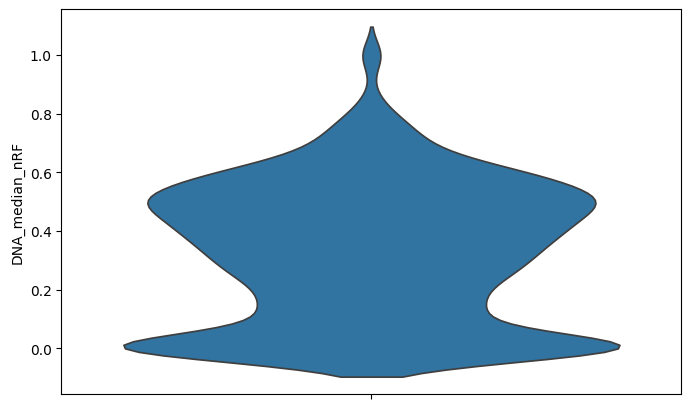

In [90]:
import seaborn as sns 

plt.figure(figsize=(8, 5))
sns.violinplot(
    data=df_normRF,
    y=df_normRF['DNA_median_nRF'],       # don’t extend beyond the data; keeps bottom at 0 cleanly
    inner=None    # no internal box/median lines
)

print(f"{len(df_normRF[df_normRF['DNA_median_nRF']==0])} show no difference.")
print(f"{len(df_normRF[df_normRF['DNA_median_nRF']!=0.0])} has difference.")

263 show no difference.
2565 has difference.


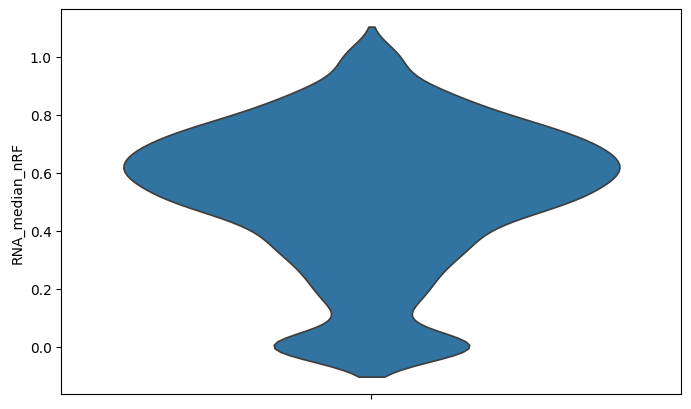

In [91]:
plt.figure(figsize=(8, 5))
sns.violinplot(
    data=df_normRF,
    y=df_normRF['RNA_median_nRF'],       # don’t extend beyond the data; keeps bottom at 0 cleanly
    inner=None    # no internal box/median lines
)

print(f"{len(df_normRF[df_normRF['RNA_median_nRF']==0])} show no difference.")
print(f"{len(df_normRF[df_normRF['RNA_median_nRF']!=0.0])} has difference.")

In [ ]:
# We’ll plot only these two categories from this table
order = ['DNA vs DNA', 'DNA vs RNA']

# Keep only rows we need and drop any NaNs in the y column
# df_plot = (
#     df[df['Category'].isin(order)]
#       .copy()
#       .dropna(subset=['Median RF'])
# )
df_normRF_plot = (
    df[df['Category'].isin(order)]
      .copy()
      .dropna(subset=['Median RF'])
)
# Colors: light gray for DNA vs DNA; pick a distinct color for DNA vs RNA
palette = {
    'DNA vs DNA': 'lightgray',
    'DNA vs RNA': '#1f77b4',  # blue; change if you prefer another color
}

# Compute a little headroom for the y-axis
#ymax = df_plot['Median RF'].max()

plt.figure(figsize=(8, 5))
sns.violinplot(
    data=df_normRF,
    x='Category',
    y='Median RF',
    order=order,
    palette=palette,
    cut=0,        # don’t extend beyond the data; keeps bottom at 0 cleanly
    inner=None    # no internal box/median lines
)

plt.ylim(0, ymax * 1.15)   # bottom pinned at 0; top auto with headroom
plt.xticks(rotation=20, ha='right')
plt.title('Median Normalised Robinson–Foulds Distance -- Model S6A for full-alignment dataset')
plt.ylabel('Median Normalised RF')
plt.xlabel('')
plt.tight_layout()
plt.show()

# (optional) print quick summaries
print("Group medians:")
print(df_plot.groupby('Category')['Median RF'].median().round(4))
print("\nGroup means:")
print(df_plot.groupby('Category')['Median RF'].mean().round(4))

# Draft

In [54]:
df[df['RNA'] == 'RF03929']

,RNA,Category,Mean RF,Median RF
5595,RF03929,DNA vs DNA,0.0,0.0
5596,RF03929,DNA vs RNA,0.0,0.0
5597,RF03929,RNA vs RNA,0.0,0.0
